# Pnevmatikakis 2014 : Greedy Initialization Algorithm

In [2]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
import mpld3

In [3]:
import neuralyzer
from neuralyzer.im import smff

In [4]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (8,8)

In [5]:
#datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel0_13000_14000.tif'
#datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel0.tif'
datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
data = neuralyzer.get_data(datafile)

[ 2015-04-17 17:12:59 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-17 17:12:59 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-17 17:12:59 ] [ data_handler ] [ DEBUG ] : root_path set to /home/michael/lib/neuralyzer/notebooks/dev
[ 2015-04-17 17:12:59 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif.hdf5


### reshape the data

In [6]:
datashape = data.shape
data = data.reshape((data.shape[0], data.shape[1]*data.shape[2])).T
data.shape

(65536, 1000)

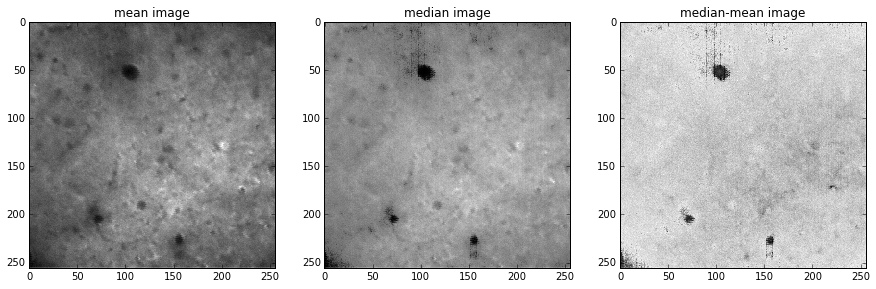

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
meanim = np.mean(data, axis=1).reshape(256,256)
ax[0].imshow(meanim)
ax[0].set_title('mean image')
medianim = np.median(data, axis=1).reshape(256,256)
ax[1].imshow(medianim)
ax[1].set_title('median image')
ax[2].imshow(medianim-meanim)
ax[2].set_title('median-mean image')

### centering the data

In [10]:
Y = data - np.array(data.shape[1]*[np.median(data,axis=1)]).T

In [11]:
Y.shape

(65536, 1000)

## Correlation Image

In [8]:
data.shape

(65536, 1000)

In [104]:
def get_neighbours_1D(x, size):
    if x >= size:
        raise ValueError('x is bigger than size allows.')
    if x == 0:
        xn = [x, x+1]
    elif x == size-1:
        xn = [x-1, x]
    else:
        xn = [x-1, x, x+1]
    return xn
        

def get_neighbours_2D(x,y, imsize):
    mask = np.zeros(imsize)
    xn = get_neighbours_1D(x, imsize[0])
    yn = get_neighbours_1D(y, imsize[1])
    ns = [(xi, yi) for xi in xn for yi in yn]
    ns.remove((x,y))
    return ns


def mask_neighbours(x, y, imshape):
    mask = np.zeros(imshape, dtype='uint8')
    for (xi, yi) in get_neighbours_2D(x, y, imshape):
        mask[xi, yi] = 1
    return mask.astype('bool')


def mask_random_pixels(N, imshape):
    '''
    N is just the number of times a pixel is drawn.
    If N gets close to the total number of pixels N will definitely not 
    be the number of maskes pixels!
    '''
    mask = np.zeros(imshape, 'uint8').flatten()
    mask[np.random.randint(len(mask)-1, size=(10, 1))] = 1
    return mask.reshape(imshape[0], imshape[1]).astype('bool')

In [108]:
np.where(mask_random_pixels(5, (10,10)).flatten() == True)

(array([ 2, 12, 15, 25, 33, 56, 65, 75, 89, 95]),)

In [123]:
def normalize_imagestack(ims):
    ''' Normalize it! What else?
    '''
    ims = ims.copy()
    N, y, x = ims.shape
    ims = ims.reshape(N, y*x)
    ims = ims - np.tile(ims.mean(axis=0), (ims.shape[0], 1))
    ims = ims /np.tile(ims.std(axis=0), (ims.shape[0], 1))
    return ims.reshape(N,y,x)



def correlation_image(imagestack):
    ''' A function that calculates a correlation image from an image stack.
    
    The correlation image is calculated for each pixels by computing 
    the mean correlation of the pixel with its neighbouring pixels.
    
    @arguments: imagestack with dims [N, y, x]
    @returns: correlationimage
    '''
    N, y, x = imagestack.shape
    npix = y*x
    ims = normalize_imagestack(imagestack)
    ims = ims.reshape(N,npix)
    cim = np.zeros((x,y))
    for idx in range(npix):
        (xi, yi) = int(idx/x), np.mod(idx, x)
        nm = mask_neighbours(xi, yi, (x,y)).flatten()
        cim[xi, yi] = np.dot(ims[:, idx], ims[:, nm]).mean()
    return cim

In [10]:
ims = data.T.reshape(1000, 256, 256)

In [122]:
ims_norm = normalize_imagestack(ims)

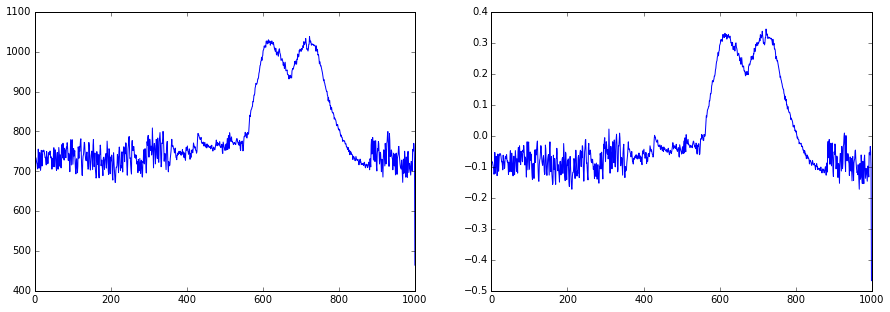

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].plot(ims.reshape(1000, 65536).mean(axis=1))
ax[1].plot(ims_norm.reshape(1000, 65536).mean(axis=1))

In [124]:
corrim = correlation_image(ims)

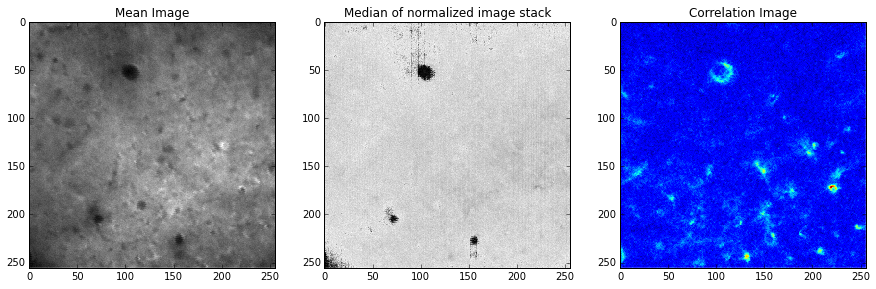

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(ims.mean(axis=0))
ax[0].set_title('Mean Image')
ax[1].imshow(np.median(ims_norm,axis=0))
ax[1].set_title('Median of normalized image stack')
ax[2].imshow(corrim, cmap='jet')
ax[2].set_title('Correlation Image')

## Gaussian Kernel

In [9]:
def gauss_kernel(size, var=None):    
    if type(size) == int:
        size = (size, size)
    else:
        raise ValueError('We only provide symmetric kernels with sizes specified by an int.')
    if not np.mod(size[0],2) or not np.mod(size[1],2):
        raise ValueError('The size of the Kernel has to be odd.')
    s = (int(size[0]/2.), int(size[0]/2.))
    if var is None: v = s
    elif type(var) == int: v = (var, var)
    else: v = var
    x, y = np.mgrid[-s[0]:s[0]+1, -s[1]:s[1]+1]
    g = np.exp(-(x**2/(2*float(v[0]))+y**2/(2*float(v[1]))))
    return g / g.sum()

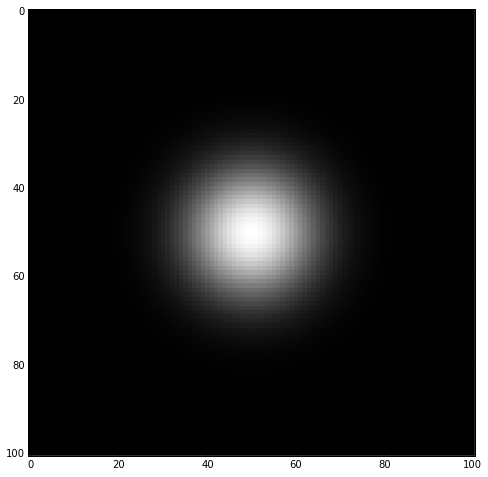

In [10]:
size = 101
g = gauss_kernel(size, size)
plt.imshow(g)

In [11]:
def gaussian_blur_matrix(dim, kernelsize, kernelvariance):
    from scipy import sparse
    kernel = gauss_kernel(kernelsize, kernelvariance).flatten()
    kl = len(kernel)
    D = np.zeros((dim, dim+kl-1))
    for idx in range(dim):
        D[idx,idx:idx+kl] = kernel
    D = D[:,((kl-1)/2):-(kl-1)/2]
    return sparse.dia_matrix(D.T)

In [12]:
data.shape

(262144, 1000)

In [ ]:
D = gaussian_blur_matrix(data.shape[0], 41, 20)

In [13]:
D.shape

(262144, 262144)

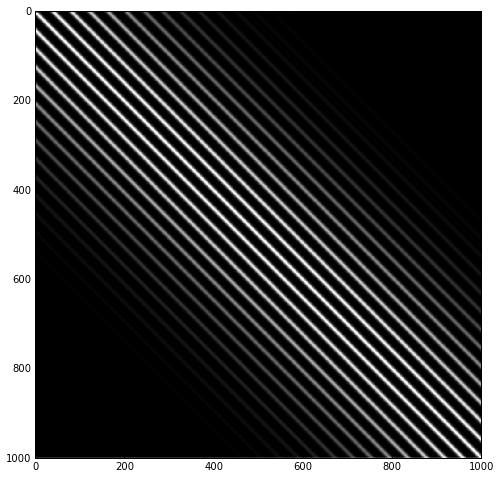

In [20]:
plt.imshow(D[:1000, :1000])

In [8]:
data.shape

(262144, 1000)

In [22]:
def greedy_neuron_id(Y, K, tau, w):
    med = np.median(Y, axis=1)
    MED = np.array(Y.shape[0]*[med])
    Y = Y - MED
    R = Y.copy()
    D = gaussian_blur_matrix(Y.shape[0], w, tau)
    for i in range(K):
        rho = np.dot(D.T, R)
        v = 

In [3]:
D = smff.gaussian_blur_matrix_sparse(262144, 41, 20)

In [10]:
Y = data.copy()
med = np.median(Y, axis=1)
MED = np.array(Y.shape[1]*[med]).T
Y = Y - MED
R = Y.copy()

In [11]:
R.shape

(262144, 1000)

In [ ]:
rho = np.dot(D,data)

In [10]:
rho.shape

(262144, 1000)

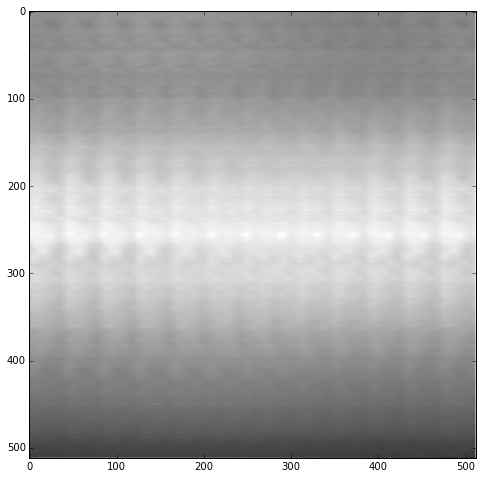

In [14]:
plt.imshow(rho.mean(axis=1).reshape(512,512))

In [15]:
a = np.array([[1,2,],[3,4,]])
b = np.array([[10,20,],[30,40,]])

In [16]:
a

array([[1, 2],
       [3, 4]])

In [17]:
b

array([[10, 20],
       [30, 40]])

In [19]:
np.dot(a,b)

array([[ 70, 100],
       [150, 220]])

In [16]:
D.size

68719476736

In [15]:
from scipy import sparse

In [21]:
sparse.coo_matrix?

In [22]:
sparse.dia_matrix?

In [ ]:
Ds = sparse.dia_matrix(D)